# 사람에게 물어보는 노드

지금까지는 메시지들의 상태(State) 에 의존해 왔습니다. 

이런 상태 값들의 수정으로도 많은 것을 할 수 있지만, 메시지 목록에만 의존하지 않고 복잡한 동작을 정의하고자 한다면 상태에 추가 필드를 더할 수 있습니다. 이 튜토리얼에서는 새로운 노드를 추가하여 챗봇을 확장하는 방법을 설명합니다.

위의 예에서는 도구가 호출될 때마다 **interrupt 를 통해 그래프가 항상 중단** 되도록 Human-in-the-loop 을 구현하였습니다. 

이번에는, 챗봇이 인간에 의존할지 선택할 수 있도록 하고 싶다고 가정해 봅시다.

이를 수행하는 한 가지 방법은 그래프가 항상 멈추는 **"human" 노드** 를 생성하는 것입니다. 이 노드는 LLM이 "human" 도구를 호출할 때만 실행됩니다. 편의를 위해, 그래프 상태에 "ask_human" 플래그를 포함시켜 LLM이 이 도구를 호출하면 플래그를 전환하도록 할 것입니다.

In [17]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [1]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Modules")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Modules


## 사람에게 의견을 묻는 노드 설정

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

/Users/minjeong/Library/Caches/pypoetry/virtualenvs/langchain-kr-szXyjQUn-py3.11/lib/python3.11/site-packages/pydantic/_internal/_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'validate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


이번에는 중간에 사람에게 질문할지 여부를 묻는 상태(`ask_human`)를 추가합니다.

In [3]:
class State(TypedDict):
    # 메시지 목록
    messages: Annotated[list, add_messages]
    # 사람에게 질문할지 여부를 묻는 상태 추가
    ask_human: bool

`human` 에 대한 요청시 사용되는 스키마를 정의합니다.

In [4]:
from pydantic import BaseModel


class HumanRequest(BaseModel):
    """Forward the conversation to an expert. Use when you can't assist directly or the user needs assistance that exceeds your authority.
    To use this function, pass the user's 'request' so that an expert can provide appropriate guidance.
    """

    request: str

다음으로, 챗봇 노드를 정의합니다. 

여기서 주요 수정 사항은 챗봇이 `RequestAssistance` 플래그를 호출한 경우 `ask_human` 플래그를 전환하는 것입니다.

In [5]:
from langchain_openai import ChatOpenAI

# 도구 추가
tool = TavilySearch(max_results=3)

# 도구 목록 추가(HumanRequest 도구)
tools = [tool, HumanRequest]

# LLM 추가
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# 도구 바인딩
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    # LLM 도구 호출을 통한 응답 생성
    response = llm_with_tools.invoke(state["messages"])

    # 사람에게 질문할지 여부 초기화
    ask_human = False

    # 도구 호출이 있고 이름이 'HumanRequest' 인 경우
    if response.tool_calls and response.tool_calls[0]["name"] == HumanRequest.__name__:
        ask_human = True

    # 메시지와 ask_human 상태 반환
    return {"messages": [response], "ask_human": ask_human}

다음으로, 그래프 빌더를 생성하고 이전과 동일하게 `chatbot` 과 `tools` 노드를 그래프에 추가합니다.

In [6]:
# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
graph_builder.add_node("tools", ToolNode(tools=[tool]))

## Human 노드 설정

다음으로 `human` 노드를 생성합니다. 

이 노드는 주로 그래프에서 인터럽트를 트리거하는 자리 표시자 역할을 합니다. 사용자가 `interrupt` 동안 수동으로 상태를 업데이트하지 않으면, LLM이 사용자가 요청을 받았지만 응답하지 않았음을 알 수 있도록 도구 메시지를 삽입합니다. 

이 노드는 또한 `ask_human` 플래그를 해제하여 추가 요청이 없는 한 그래프가 노드를 다시 방문하지 않도록 합니다.

> 참고 이미지

![](image/langgraph-07.jpeg)

In [7]:
from langchain_core.messages import AIMessage, ToolMessage


# 응답 메시지 생성(ToolMessage 생성을 위한 함수)
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


# 인간 노드 처리
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # 사람으로부터 응답이 없는 경우
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # 새 메시지 추가
        "messages": new_messages,
        # 플래그 해제
        "ask_human": False,
    }


# 그래프에 인간 노드 추가
graph_builder.add_node("human", human_node)

다음으로, 조건부 논리를 정의합니다. 

`select_next_node`는 플래그가 설정된 경우 `human` 노드로 경로를 지정합니다. 그렇지 않으면, 사전 구축된 `tools_condition` 함수가 다음 노드를 선택하도록 합니다.

`tools_condition` 함수는 단순히 `chatbot`이 응답 메시지에서 `tool_calls`을 사용했는지 확인합니다. 

사용한 경우, `action` 노드로 경로를 지정합니다. 그렇지 않으면, 그래프를 종료합니다.

In [8]:
from langgraph.graph import END


# 다음 노드 선택
def select_next_node(state: State):
    # 인간에게 질문 여부 확인
    if state["ask_human"]:
        return "human"
    # 이전과 동일한 경로 설정
    return tools_condition(state)


# 조건부 엣지 추가
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

마지막으로 엣지를 연결하고 그래프를 컴파일합니다.

In [9]:
# 엣지 추가: 'tools'에서 'chatbot'으로
graph_builder.add_edge("tools", "chatbot")

# 엣지 추가: 'human'에서 'chatbot'으로
graph_builder.add_edge("human", "chatbot")

# 엣지 추가: START에서 'chatbot'으로
graph_builder.add_edge(START, "chatbot")

# 메모리 저장소 초기화
memory = MemorySaver()

# 그래프 컴파일: 메모리 체크포인터 사용
graph = graph_builder.compile(
    checkpointer=memory,
    # 'human' 이전에 인터럽트 설정
    interrupt_before=["human"],
)

그래프를 시각화 합니다.

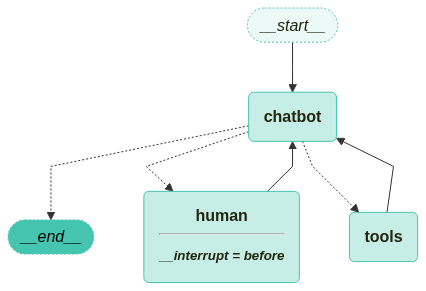

In [10]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

`chatbot` 노드는 다음과 같은 동작을 합니다.

- 챗봇은 인간에게 도움을 요청할 수 있으며 (chatbot->select->human)
- 검색 엔진 도구를 호출하거나 (chatbot->select->action)
- 직접 응답할 수 있습니다 (chatbot->select->__end__). 

일단 행동이나 요청이 이루어지면, 그래프는 `chatbot` 노드로 다시 전환되어 작업을 계속합니다. 

In [11]:
# user_input = "이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 검색해서 답변하세요" (Human 이 아닌 웹검색을 수행하는 경우)
user_input = "이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?"

# config 설정
config = {"configurable": {"thread_id": "1"}}

# 스트림 또는 호출의 두 번째 위치 인수로서의 구성
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================ Human Message =================================

이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (call_rlK0d1j3rLNbo3uymDOo5SE9)
 Call ID: call_rlK0d1j3rLNbo3uymDOo5SE9
  Args:
    request: AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다.


**Notice:** `LLM`이 제공된 "`HumanRequest`" 도구를 호출했으며, 인터럽트가 설정되었습니다. 그래프 상태를 확인해 봅시다.

In [12]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태 접근
snapshot.next

('human',)

그래프 상태는 실제로 `'human'` 노드 이전에 **중단**됩니다. 

이 시나리오에서 "전문가"로서 행동하고 입력을 사용하여 새로운 `ToolMessage`를 추가하여 상태를 수동으로 업데이트할 수 있습니다.

다음으로, 챗봇의 요청에 응답하려면 다음을 수행합니다.

1. 응답을 포함한 `ToolMessage`를 생성합니다. 이는 `chatbot`에 다시 전달됩니다.
2. `update_state`를 호출하여 그래프 상태를 수동으로 업데이트합니다.

In [13]:
# AI 메시지 추출
ai_message = snapshot.values["messages"][-1]

# 인간 응답 생성
human_response = (
    "전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. "
    "단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. "
    "https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다."
)

# 도구 메시지 생성
tool_message = create_response(human_response, ai_message)

# 그래프 상태 업데이트
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f05fec3-b221-67fc-8002-d53df70e88f9'}}

상태를 확인하여 응답이 추가되었는지 확인할 수 있습니다.

In [14]:
# 그래프 상태에서 메시지 값 가져오기
graph.get_state(config).values["messages"]

[HumanMessage(content='이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?', additional_kwargs={}, response_metadata={}, id='98af5819-0989-4862-9a3f-980da1096053'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_rlK0d1j3rLNbo3uymDOo5SE9', 'function': {'arguments': '{"request":"AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다."}', 'name': 'HumanRequest'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 171, 'total_tokens': 201, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--39a2e3db-7733-4aeb-8bc1-3e6116123d73-0', tool_calls=[{'name': 'HumanRequest', 'args': {'request': 'AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다.'}, 'id': 'call_rlK0d1j3rL

다음으로, 입력값으로 `None`을 사용하여 그래프를 **resume**합니다.

In [15]:
# 그래프에서 이벤트 스트림 생성
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    # 메시지가 있는 경우 마지막 메시지 출력
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청했습니다. LangGraph를 확인해 보시기를 추천드립니다. 이 플랫폼은 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. 더 많은 정보는 [여기](https://wikidocs.net/233785)에서 확인하실 수 있습니다.


최종 결과를 확인합니다.

In [16]:
# 최종 상태 확인
state = graph.get_state(config)

# 단계별 메시지 출력
for message in state.values["messages"]:
    message.pretty_print()

================================ Human Message =================================

이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (call_rlK0d1j3rLNbo3uymDOo5SE9)
 Call ID: call_rlK0d1j3rLNbo3uymDOo5SE9
  Args:
    request: AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청합니다.
================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

AI 에이전트를 구축하는 데 필요한 전문가의 도움을 요청했습니다. LangGraph를 확인해 보시기를 추천드립니다. 이 플랫폼은 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. 더 많은 정보는 [여기](https://wikidocs.net/233785)에서 확인하실 수 있습니다.
